In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [6]:
import pandas as pd
import numpy as np
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, validation_curve

import xgboost as xgb

import matplotlib.pyplot as plt

from kaggle.walmart_recruiting_sales_in_stormy_weather import common

#### Считывание данных

In [7]:
key = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/key.csv")
train = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/train.csv")
test = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/test.csv")
weather = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/weather.csv")

#### Удаление товаров которые никогда не торговались

In [9]:
common.add_id_field(train)
common.add_id_field(test)

unclaimed_products = common.get_unclaimed_products(train)
unclaimed_ids_from_test = test[test['product'].isin(unclaimed_products)]['id']


#### Предобработка данных

In [11]:
weather = weather.replace('M', -1)
weather = weather.replace('  T', 0.001)

for c in set(weather.columns) - set(['date', 'codesum', 'sunrise', 'sunset']):
    weather[c] = pd.to_numeric(weather[c])
    
common.convert_to_minutes(weather['sunrise'])
common.convert_to_minutes(weather['sunset'])

mlb = MultiLabelBinarizer()
codesum_data = pd.DataFrame(mlb.fit_transform(weather['codesum'].str.split()),columns=mlb.classes_)
weather_codesum = weather.join(codesum_data.sort_index(axis=1))


preprocessed_train = common.preprocessing(train[~train['product'].isin(unclaimed_products)], key, weather_codesum)
preprocessed_test = common.preprocessing(test[~test['product'].isin(unclaimed_products)], key, weather_codesum)

train_columns = preprocessed_train.columns
test_columns = preprocessed_test.columns
diff_columns = list(set(train_columns) - set(test_columns))
diff_columns.remove(common.TARGET_NAME)
print("Diff of columns {}". format(diff_columns))
for column in diff_columns:
    preprocessed_test[column] = 0 # Add missing field after onehot encoding

/home/skrrydg/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Diff of columns []


#### Валидационнная кривая

In [26]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]

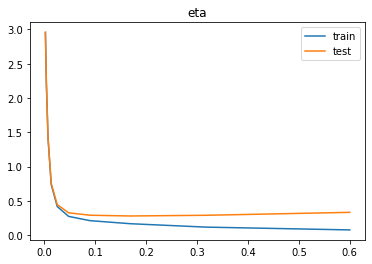

In [28]:
data = np.geomspace(0.002, 0.6, 10)
train_scoreNum, test_scoreNum = validation_curve(
                                xgb.XGBRegressor(booster="gbtree", eval_metric="rmse"),
                                X = X, y = y, 
                                param_name = 'learning_rate', 
                                param_range = data,
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.title("learning_rate")
plt.show()

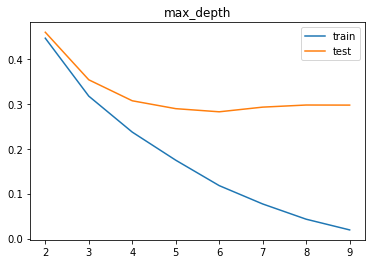

In [30]:
data = np.arange(2, 10, 1)
train_scoreNum, test_scoreNum = validation_curve(
                                xgb.XGBRegressor(booster="gbtree", eval_metric="rmse"),
                                X = X, y = y, 
                                param_name = "max_depth", 
                                param_range = data,
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.title("max_depth")
plt.show()

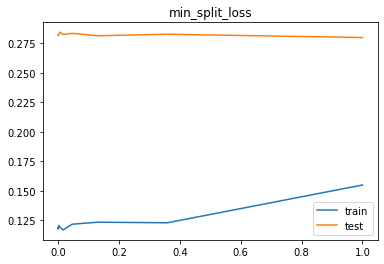

In [34]:
data = np.geomspace(0.0001, 1, 10)
train_scoreNum, test_scoreNum = validation_curve(
                                xgb.XGBRegressor(booster="gbtree", eval_metric="rmse"),
                                X = X, y = y, 
                                param_name = "min_split_loss", 
                                param_range = data,
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.title("min_split_loss")
plt.show()

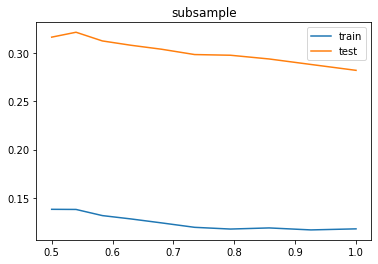

In [33]:
data = np.geomspace(0.5, 1, 10)
train_scoreNum, test_scoreNum = validation_curve(
                                xgb.XGBRegressor(booster="gbtree", eval_metric="rmse"),
                                X = X, y = y, 
                                param_name = "subsample", 
                                param_range = data,
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.title("subsample")
plt.show()

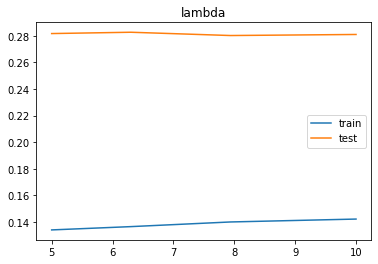

In [36]:
data = np.arange(1, 10)
train_scoreNum, test_scoreNum = validation_curve(
                                xgb.XGBRegressor(booster="gbtree", eval_metric="rmse"),
                                X = X, y = y, 
                                param_name = "lambda", 
                                param_range = data,
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.title("lambda")
plt.show()

#### Кросвалидация

In [ ]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]


max_depths = range(5, 10)
learning_rates = np.geomspace(0.002, 0.6, 10)


hyperF = dict(learning_rate=learning_rates, max_depth = max_depths)

model = xgb.XGBRegressor(booster="gbtree", eval_metric="rmse")

model.fit(X, y)

gridF = GridSearchCV(model, 
                     hyperF, 
                     cv = 3, 
                     verbose = 1,
                     scoring='neg_mean_squared_error')

bestF = gridF.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print(bestF.best_params_, -bestF.best_score_)

#### Обучение модели

In [40]:
y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

In [41]:
model = xgb.XGBRegressor(booster="gbtree", eval_metric="rmse", n_estimators=500, **bestF.best_params_) 

In [42]:
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.16891952847063652,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Предсказание

In [43]:
y_predict = model.predict(preprocessed_test)
y_predict = np.exp(y_predict) - 1

In [44]:
cleared_test = test[~test['product'].isin(unclaimed_products)]
_id = (cleared_test["store_nbr"].astype("str") + "_" + cleared_test["item_nbr"].astype("str") + "_" + cleared_test["date"].astype('str')).to_numpy()
_units = y_predict

In [45]:
_id = np.append(_id, unclaimed_ids_from_test)
_units = np.append(_units, np.zeros(shape=(len(unclaimed_ids_from_test))))

In [48]:
prediction = pd.DataFrame(data={"id": _id, "units": _units}).set_index("id") 
prediction.to_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/submissions/XGBoost.csv")